# Comparing ground truth with Prince

In this notebook, we compare the width computed with the high magnification microscope (x100) to those taken with Prince.\
Groundtruth labels: must be set with label me (using the old file for now)

## Setup

In [16]:
import os
import json

In [121]:
from amftrack.util.image_analysis import get_transformation
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    plot_edge,
    find_nearest_edge,
    get_all_edges,
    plot_full_image_with_features,
)

In [122]:
from amftrack.pipeline.functions.image_processing.experiment_util import (
    find_neighboring_edges,
)

ImportError: cannot import name 'find_neighboring_edges' from 'amftrack.pipeline.functions.image_processing.experiment_util' (/home/ipausers/kahane/Wks/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_util.py)

In [12]:
from amftrack.util.geometry import (
    generate_index_along_sequence,
    distance_point_pixel_line,
    get_closest_lines,
)

In [13]:
from amftrack.util.sys import storage_path

In [2]:
from amftrack.util.sys import (
    storage_path,
    get_current_folders_local,
    update_plate_info_local,
)
from amftrack.util.file import chose_file
from amftrack.util.plot import show_image
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
)
import os
import numpy as np
import matplotlib.pyplot as plt
import logging

%matplotlib notebook

### Experiment object

In [3]:
directory_name = "width1"
plate_name = "20220325_1423_Plate907"
directory = os.path.join(storage_path, directory_name, "full_plates") + "/"

update_plate_info_local(directory)
folder_df = get_current_folders_local(directory)
selected_df = folder_df.loc[folder_df["folder"] == plate_name]
i = 0
plate = int(list(selected_df["folder"])[i].split("_")[-1][5:])
folder_list = list(selected_df["folder"])
directory_name = folder_list[i]
exp = Experiment(directory)
exp.load(selected_df.loc[selected_df["folder"] == directory_name], labeled=False)

2022-03-25 14:23:00


In [4]:
selected_df

,total_path,Plate,PrincePos,root,strain,medium,split,Pbait,CrossDate,Temperature,...,/Analysis/skeleton_masked_compressed.mat,/Analysis/skeleton_pruned_compressed.mat,/Analysis/transform.mat,/Analysis/transform_corrupt.mat,/Analysis/skeleton_realigned_compressed.mat,/Analysis/nx_graph_pruned.p,/Analysis/nx_graph_pruned_width.p,/Analysis/nx_graph_pruned_labeled.p,date,folder
1,/media/kahane/AMFtopology02/storage/width1/ful...,907,9,'Carrot','A5','001P100N100C','Y','-',20220321,25,...,True,True,False,False,True,True,False,False,"25.03.2022, 14:23:",20220325_1423_Plate907


In [5]:
selected_df = folder_df.loc[folder_df["folder"] == plate_name]

In [6]:
i = 0

In [7]:
plate = int(list(selected_df["folder"])[i].split("_")[-1][5:])
folder_list = list(selected_df["folder"])
directory_name = folder_list[i]

In [8]:
exp = Experiment(directory)
exp.load(selected_df.loc[selected_df["folder"] == directory_name], labeled=False)

2022-03-25 14:23:00


In [9]:
len(exp.nx_graph[0])

2407

In [10]:
exp.load_tile_information(0)

### Labels

In [68]:
R = np.array([[0.99934915, -0.03607328], [0.03607328, 0.99934915]])
t = np.array([-8486.74354496, 4919.45372883])

In [69]:
f = get_transformation(R, t)

In [70]:
file_path = os.path.join(storage_path, "width1", "measures", "data_width_907_3.json")
with open(file_path) as fil:
    d = json.load(fil)

In [71]:
d

{'trunk_001': {'plate': '20220324_Plate907_001',
  'values': [249, 241, 252, 240, 241, 244],
  'hypha': 1,
  'pos': 'middle',
  'order': 9,
  'x': 68260,
  'y': 54300,
  'value': 244,
  'variance': 20,
  'std_deviation': 4},
 'trunk_002': {'plate': '20220324_Plate907_003',
  'values': [230, 236, 231, 277, 245, 242],
  'hypha': 1,
  'pos': 'middle',
  'order': 8,
  'x': 68540,
  'y': 51840,
  'value': 243,
  'variance': 253,
  'std_deviation': 15},
 'trunk_003': {'plate': '20220324_Plate907_005',
  'values': [218, 210, 198, 201, 210, 222],
  'hypha': 1,
  'pos': 'middle',
  'order': 7,
  'x': 68420,
  'y': 49340,
  'value': 209,
  'variance': 72,
  'std_deviation': 8},
 'trunk_004': {'plate': '20220324_Plate907_007',
  'values': [163, 179, 176, 190],
  'hypha': 1,
  'pos': 'top',
  'order': 6,
  'x': 68640,
  'y': 46880,
  'value': 177,
  'variance': 92,
  'std_deviation': 9},
 'trunk_005': {'plate': '20220324_Plate907_007',
  'values': [210, 220, 210, 180],
  'hypha': 1,
  'pos': 'bott

In [72]:
coordinates = []
for key in d:
    # We convert to pixel and invert x and y and convert to int
    old_coord = np.array([int(d[key]["y"] / 1.725), int(d[key]["x"] / 1.725)])
    coordinates.append(f(old_coord))
    d[key]["coord"] = f(old_coord)

## 0. Verify that the R and t transformation is right

In [73]:
edges = get_all_edges(exp, 0)

In [74]:
len(edges)

1652

<IPython.core.display.Javascript object>


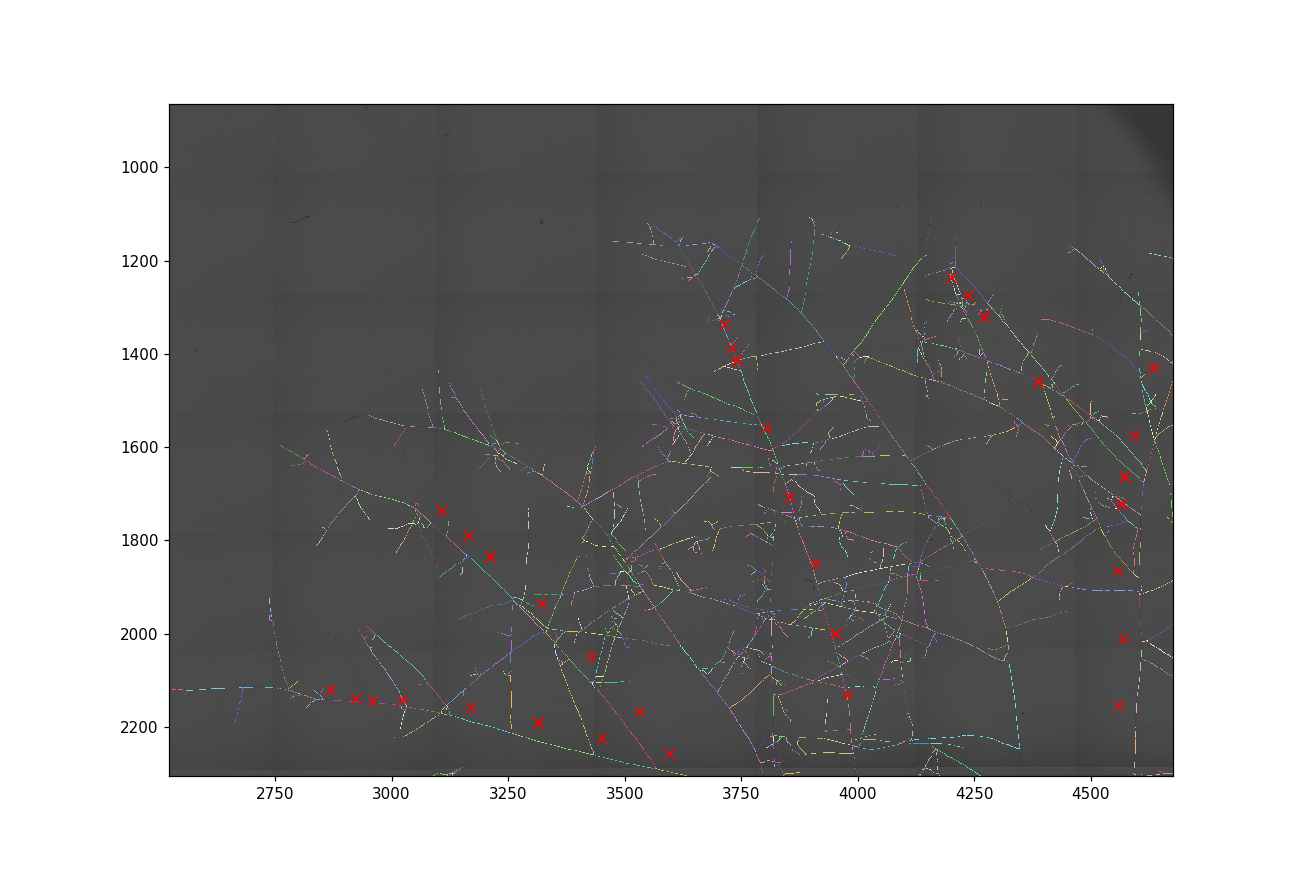

In [75]:
plot_full_image_with_features(
    exp, 0, downsizing=10, edges=edges, dilation=1, points=coordinates
)

## 1. Find the neigbooring edges

In [100]:
def find_neighboring_edges(point, exp, t: int, n_nearest=5, step=50):
    edges = get_all_edges(exp, t)
    l = [edge.pixel_list(t) for edge in edges]
    indexes = get_closest_lines(point, l, step=50, n_nearest=10)[0]
    kept_edges = [edges[i] for i in indexes]
    return kept_edges

In [113]:
def flatten(l):
    L = []
    for a in l:
        for b in a:
            L.append(b)
    return L

In [114]:
l = [[edge.begin, edge.end] for edge in kept_edges]

In [115]:
L = flatten(l)

In [117]:
len(L)

20

In [118]:
L_ = list(set(L))

In [119]:
L_

[Node(2048),
 Node(2213),
 Node(2443),
 Node(2444),
 Node(2574),
 Node(2031),
 Node(2013),
 Node(3159),
 Node(2617),
 Node(1980),
 Node(2813)]

In [101]:
point = coordinates[1]

In [102]:
kept_edges = find_neighboring_edges(point, exp, 0)

<IPython.core.display.Javascript object>


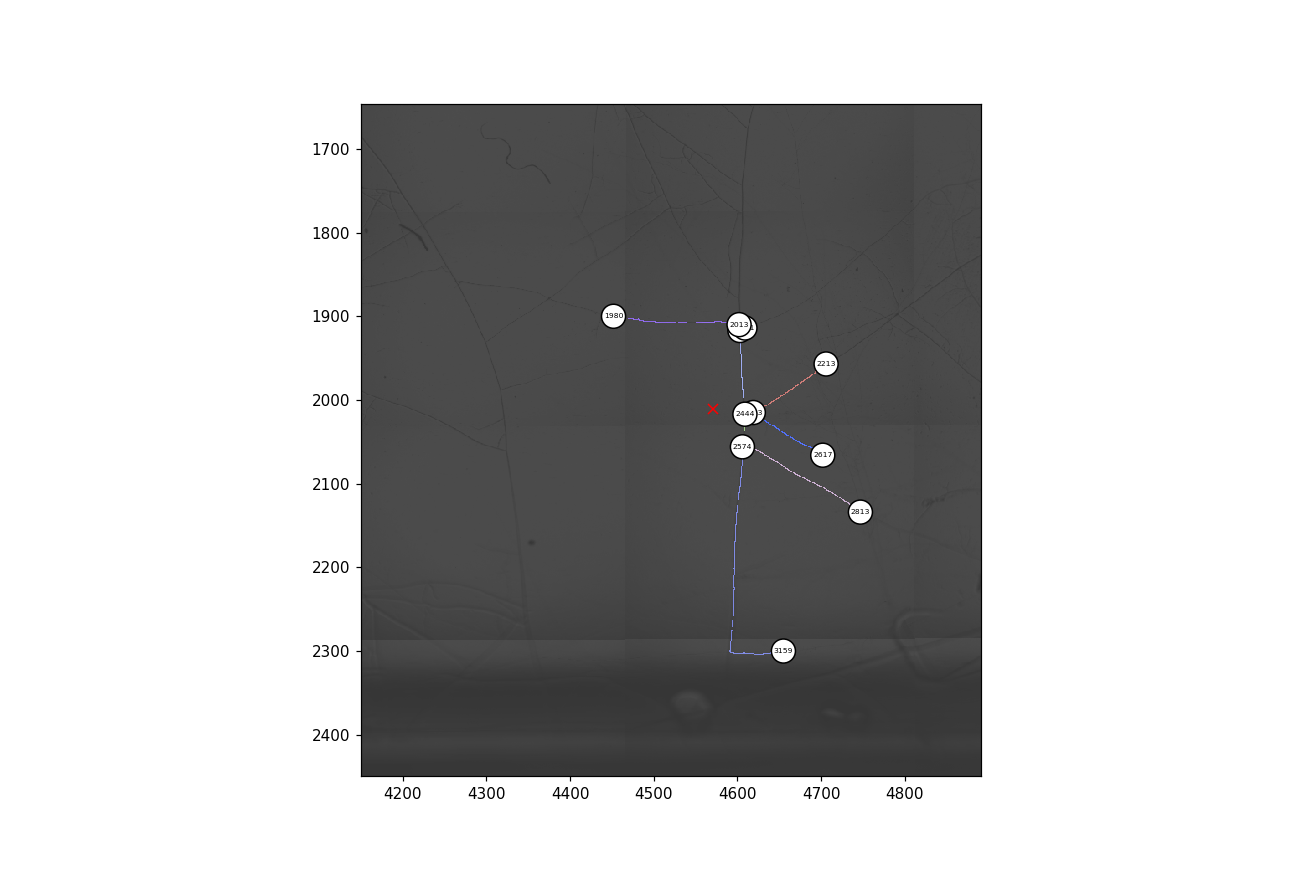

In [120]:
plot_full_image_with_features(
    exp, 0, downsizing=10, edges=kept_edges, dilation=1, points=[point], nodes=L_
)